# AIT Development notebook

## notebook of structure

| #  | Name                                               | cells | for_dev | edit               | description                                                                |
|----|----------------------------------------------------|-------|---------|--------------------|----------------------------------------------------------------------------|
| 1  | [Environment detection](##1-Environment-detection) | 1     | No      | uneditable         | detect whether the notebook are invoked for packaging or in production     |
| 2  | [Preparing AIT SDK](##2-Preparing-AIT-SDK)         | 1     | Yes     | uneditable         | download and install AIT SDK                                               |
| 3  | [Dependency Management](##3-Dependency-Management) | 3     | Yes     | required(cell #2)  | generate requirements.txt for Docker container                             |
| 4  | [Importing Libraries](##4-Importing-Libraries)     | 2     | Yes     | required(cell #1)  | import required libraries                                                  |
| 5  | [Manifest Generation](##5-Manifest-Generation)     | 1     | Yes     | required           | generate AIT Manifest                                                      |
| 6  | [Prepare for the Input](##6-Prepare-for-the-Input) | 1     | Yes     | required           | generate AIT Input JSON (inventory mapper)                                 |
| 7  | [Initialization](##7-Initialization)               | 1     | No      | uneditable         | initialization for AIT execution                                           |
| 8  | [Function definitions](##8-Function-definitions)   | N     | No      | required           | define functions invoked from Main area.<br> also define output functions. |
| 9  | [Main Algorithms](##9-Main-Algorithms)             | 1     | No      | required           | area for main algorithms of an AIT                                         |
| 10 | [Entry point](##10-Entry-point)                    | 1     | No      | uneditable         | an entry point where Qunomon invoke this AIT from here                     |
| 11 | [License](##11-License)                            | 1     | Yes     | required           | generate license information                                               |
| 12 | [Deployment](##12-Deployment)                      | 1     | Yes     | uneditable         | convert this notebook to the python file for packaging purpose             |

## notebook template revision history

1.0.1 2020/10/21

* add revision history
* separate `create requirements and pip install` editable and noeditable
* separate `import` editable and noeditable

1.0.0 2020/10/12

* new cerarion

## body

### #1 Environment detection

[uneditable]

In [1]:
# Determine whether to start AIT or jupyter by startup argument
import sys
is_ait_launch = (len(sys.argv) == 2)

### #2 Preparing AIT SDK

[uneditable]

In [2]:
if not is_ait_launch:
    # get ait-sdk file name
    from pathlib import Path
    from glob import glob
    import re
    import os

    current_dir = %pwd

    ait_sdk_path = "./ait_sdk-*-py3-none-any.whl"
    ait_sdk_list = glob(ait_sdk_path)
    ait_sdk_name = os.path.basename(ait_sdk_list[-1])

    # install ait-sdk
    !pip install -q --upgrade pip
    !pip install -q --no-deps --force-reinstall ./$ait_sdk_name

### #3 Dependency Management

#### #3-1 [uneditable]

In [3]:
if not is_ait_launch:
    from ait_sdk.common.files.ait_requirements_generator import AITRequirementsGenerator
    requirements_generator = AITRequirementsGenerator()

#### #3-2 [required]

In [4]:
if not is_ait_launch:
    requirements_generator.add_package('torch','2.7.0')
    requirements_generator.add_package('torchmetrics', '1.6.2')
    requirements_generator.add_package('ultralytics', '8.3.139')
    requirements_generator.add_package('pandas', '2.2.3')
    requirements_generator.add_package('numpy','2.0.2')
    requirements_generator.add_package('opencv-python-headless','4.11.0.86')
    requirements_generator.add_package('h5py','3.12.1')
    requirements_generator.add_package('matplotlib','3.10.0')
    requirements_generator.add_package('scikit-learn','1.6.1')
    requirements_generator.add_package('pycocotools', '2.0.8')

#### #3-3 [uneditable]

In [5]:
if not is_ait_launch:
    requirements_generator.add_package(f'./{ait_sdk_name}')
    requirements_path = requirements_generator.create_requirements(current_dir)

    !pip install -q -r $requirements_path 

  DEPRECATION: Building 'psutil' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'psutil'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'py-cpuinfo' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'py-cpuinfo'. Discussion can be found at https://github.com/pypa/pip/issues/6334


### #4 Importing Libraries

#### #4-1 [required]

In [6]:
import h5py
import numpy as np
import pandas as pd
import csv
from collections import Counter
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from torchmetrics.detection import MeanAveragePrecision
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


#### #4-2 [uneditable]

In [7]:
# must use modules
from os import path
import shutil  # do not remove
from ait_sdk.common.files.ait_input import AITInput  # do not remove
from ait_sdk.common.files.ait_output import AITOutput  # do not remove
from ait_sdk.common.files.ait_manifest import AITManifest  # do not remove
from ait_sdk.develop.ait_path_helper import AITPathHelper  # do not remove
from ait_sdk.utils.logging import get_logger, log, get_log_path  # do not remove
from ait_sdk.develop.annotation import measures, resources, downloads, ait_main  # do not remove
# must use modules

### #5 Manifest Generation

[required]

In [8]:
if not is_ait_launch:
    from ait_sdk.common.files.ait_manifest_generator import AITManifestGenerator
    manifest_generator = AITManifestGenerator(current_dir)
    manifest_generator.set_ait_name('eval_map_yolo_torch')
    manifest_generator.set_ait_description('pytorchの物体検出モデルの推論結果から、テストデータのmean Average Precision(mAP)をを算出し、精度を評価する。\\n \\begin{align}AP=\\frac{1}{N}\sum_{i=1}^{N}P(R_{i})\\end{align} \\n \\begin{align}mAP=\\frac{1}{C}\sum_{c=1}^{C}AP_{c}\\end{align}  \\n ここで、\\begin{align}R_{i}\\end{align}は異なる再現率のポイント、\\begin{align}P(R_{i})\\end{align}はその点での適合率、Cはクラス数、\\begin{align}AP_{c}\\end{align}はクラスcに対するAverage Precision(AP)')
    manifest_generator.set_ait_source_repository('https://github.com/aistairc/Qunomon_AIT_eval_map_yolo_torch')
    manifest_generator.set_ait_version('0.4')
    manifest_generator.add_ait_licenses('Apache License Version 2.0')
    manifest_generator.add_ait_keywords('AIT')
    manifest_generator.add_ait_keywords('Object Detection')
    manifest_generator.add_ait_keywords('Yolo')
    manifest_generator.add_ait_keywords('mAP')
    manifest_generator.set_ait_quality('https://ait-hub.pj.aist.go.jp/ait-hub/api/0.0.1/qualityDimensions/機械学習品質マネジメントガイドライン第三版/C-1機械学習モデルの正確性')
    #### Inventories
    inventory_requirement_dataset = manifest_generator.format_ait_inventory_requirement(format_=['h5'])
    manifest_generator.add_ait_inventories(name='test_dataset',
                                             type_='dataset',
                                             description="テスト用データセットを格納したHDF5ファイル。 HDF5ファイルの内部に2つのデータセットを用意する(1)モデルに入力される画像データセット(データセット(1)の要素数はmodelの入力層の要素数と一致)(2)各画像データのyolo形式の正解ラベル（バウンディングボックスとクラス情報）を含むデータセット(データセット(2)の要素数はmodelの出力層の要素数と一致))",
                                             requirement=inventory_requirement_dataset)
    inventory_requirement_trained_model = manifest_generator.format_ait_inventory_requirement(format_=['.torchscript'])
    manifest_generator.add_ait_inventories(name='trained_model', 
                                             type_='model', 
                                             description='TorchScript形式でexportしたYOLOの物体検出モデル（.torchscript）。入力と出力の要素数はtest_dataset inventoryと一致させる',
                                             requirement=inventory_requirement_trained_model)
    #### Parameters
    manifest_generator.add_ait_parameters(name='test_image_dataset_name',
                                          type_='str',
                                          description='HDF5形式のテスト用ファイル内の画像データセット(1)の名前.要素数はmodelの入力層の要素数と一致',
                                          default_val='image_dataset_name')
    manifest_generator.add_ait_parameters(name='test_label_dataset_name',
                                          type_='str',
                                          description='HDF5形式のテスト用ファイル内のラベルデータセット(2)の名前.クラスラベル値の数はmodelの出力層の要素数と一致',
                                          default_val='label_dataset_name')
    manifest_generator.add_ait_parameters(name='image_count',
                                          type_='int',
                                          description='使用する画像数',
                                          default_val='1000')
    manifest_generator.add_ait_parameters(name='iou_threshold',
                                          type_='int',
                                          description='平均適合率(mAP)を計算するときのIoU(Intersection over Union)の閾値',
                                          default_val='0')
    #### Measures
    manifest_generator.add_ait_measures(name='mAP',
                                        type_='float',
                                        structure='single',
                                        description='IoUの閾値がiou_thresholdのときの平均適合率')
    #### Resources
    manifest_generator.add_ait_resources(name='precision_recall_curve',
                                         type_='picture',
                                         description='各クラスのprecision_recall曲線のプロット')
    manifest_generator.add_ait_resources(name='mAP_results',
                                         type_='table',
                                         description='IoUの閾値が0.5のときの平均適合率,IoUの閾値が0.75のときの平均適合率,IoUの閾値がiou_thresholdのときの物体サイズ別(面積が0~1024,1024~9216,9216~)の平均適合率をまとめたテーブル')
    #### Downloads
    manifest_generator.add_ait_downloads(name='bboxes_iou_values',
                                         description='画像ファイルごとの真のバウンディングボックス、真のラベル、予測されたバウンディングボックス、予測ラベル、およびIoUの値を示す表')
    manifest_generator.add_ait_downloads(name='Log',
                                         description='AIT実行ログ')

    manifest_path = manifest_generator.write()

### #6 Prepare for the Input

[required]

In [9]:
if not is_ait_launch:
    from ait_sdk.common.files.ait_input_generator import AITInputGenerator
    input_generator = AITInputGenerator(manifest_path)
    input_generator.add_ait_inventories(name='trained_model',
                                        value='model/best.torchscript')
    input_generator.add_ait_inventories(name='test_dataset',
                                        value='data/bdd100k_test.h5')
    input_generator.set_ait_params("test_image_dataset_name", "images")
    input_generator.set_ait_params("test_label_dataset_name", "yolo_labels")

    input_generator.write()

### #7 Initialization

[uneditable]

In [10]:
logger = get_logger()

ait_manifest = AITManifest()
ait_input = AITInput(ait_manifest)
ait_output = AITOutput(ait_manifest)

if is_ait_launch:
    # launch from AIT
    current_dir = path.dirname(path.abspath(__file__))
    path_helper = AITPathHelper(argv=sys.argv, ait_input=ait_input, ait_manifest=ait_manifest, entry_point_dir=current_dir)
else:
    # launch from jupyter notebook
    # ait.input.json make in input_dir
    input_dir = '/usr/local/qai/mnt/ip/job_args/1/1'
    current_dir = %pwd
    path_helper = AITPathHelper(argv=['', input_dir], ait_input=ait_input, ait_manifest=ait_manifest, entry_point_dir=current_dir)

ait_input.read_json(path_helper.get_input_file_path())
ait_manifest.read_json(path_helper.get_manifest_file_path())

### do not edit cell

### #8 Function definitions

[required]

In [11]:
# YOLO用のラベルデータをリストに変換する関数
@log(logger)
def decode_all_labels(yolo_labels):
    decoded_all_labels = {}
    for num, yolo_label in enumerate(yolo_labels):
        decoded_label = yolo_label.decode("utf-8").strip()
        label_lines = decoded_label.split("\n")
        # クラスラベルとバウンディングボックスを格納した辞書を作成
        yolo_data = [{"class_id": int(line.split()[0]), "bbox": list(map(float, line.split()[1:]))} for line in label_lines]
        decoded_all_labels[num] = yolo_data
    return decoded_all_labels

# YOLO用の形式のデータを（x1, y1, x2, y2）に変換する関数
@log(logger)
def yolo_to_bbox(yolo_data_dict, img_width=640, img_height=640):
    bbox_all_labels = {}
    for image_id, yolo_data in yolo_data_dict.items():
        bbox_labels = []
        cls_labels = []
        for data in yolo_data:
            cls_id, (x_center, y_center, width, height) = data["class_id"], data["bbox"]
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_height)
            x_max = int((x_center + width / 2) * img_width)
            y_max = int((y_center + height / 2) * img_height)
            bbox_labels.append([x_min, y_min, x_max, y_max])
            cls_labels.append(cls_id)
        bbox_all_labels[image_id] = {
            "boxes": torch.tensor(bbox_labels),
            "labels": torch.tensor(cls_labels)
        }
    return bbox_all_labels

In [12]:
@log(logger)
def calculate_map(model, images, labels, threshold):
    """
    mAPを計算する関数
    """
    metric = MeanAveragePrecision(iou_type="bbox")

    for num, result in enumerate(model(images, verbose=False)):
        # 予測したバウンディングボックスとクラスラベルと信頼度の取得
        pred_boxes = result.boxes.xyxy.cpu()  # xyxy形式の予測バウンディングボックス
        pred_scores = result.boxes.conf.cpu()  # 各予測バウンディングボックスの信頼度（スコア）
        pred_labels = result.boxes.cls.cpu().to(torch.int64)  # 予測されたクラスラベル

        # 予測スコアがしきい値以下のものは除外
        valid_preds = pred_scores >= threshold
        pred_boxes = pred_boxes[valid_preds]
        pred_scores = pred_scores[valid_preds]
        pred_labels = pred_labels[valid_preds]

        # 正解ラベルからバウンディングボックスとクラスラベルの取得
        gt_boxes, gt_labels = labels[num]["boxes"], labels[num]["labels"]

        # 評価指標の更新（予測とターゲットを更新）
        metric.update(
            preds=[{"boxes": pred_boxes, "scores": pred_scores, "labels": pred_labels}],
            target=[{"boxes": gt_boxes, "labels": gt_labels}]
        )

    # mAPの算出
    mAP = metric.compute()["map"]
    return mAP

In [13]:
@log(logger)
@resources(ait_output, path_helper, 'precision_recall_curve','precision_recall_curve.png')
def plot_pr_curves(model, images, labels, threshold, num_classes, file_path: str=None):
    """
    各クラスのPR曲線をプロットし、クラスごとのAP（平均適合率）を出力する関数
    """
    all_aps = []  # 各クラスのAPを保存するリスト

    for class_id in range(num_classes):
        pred_scores_all = []
        gt_labels_all = []

        # モデルの予測結果を取得
        for num, result in enumerate(model(images, verbose=False, stream=True)):
            # 予測スコアとラベルを収集
            pred_scores = result.boxes.conf.cpu().numpy()  # 予測スコア
            pred_labels = result.boxes.cls.cpu().numpy()  # 予測ラベル

            # 正解ラベル
            gt_labels = labels[num]["labels"].cpu().numpy()

            # 閾値より低い予測スコアを無視
            high_conf_mask = pred_scores >= threshold
            pred_scores = pred_scores[high_conf_mask]
            pred_labels = pred_labels[high_conf_mask]

            # 各予測がクラスに一致するか確認
            for i in range(len(pred_scores)):
                pred_scores_all.append(pred_scores[i])  # 予測スコアを追加
                gt_labels_all.append(int(pred_labels[i] == class_id))  # クラスIDが予測ラベルに一致するかどうか

        # 1D配列に変換
        pred_scores_all = np.array(pred_scores_all)
        gt_labels_all = np.array(gt_labels_all)

        # クラスごとのPrecisionとRecallを計算
        if len(pred_scores_all) > 0:
            precision, recall, _ = precision_recall_curve(gt_labels_all, pred_scores_all)
            
            # APの計算
            ap = average_precision_score(gt_labels_all, pred_scores_all)
            all_aps.append(ap)
            
            # PR曲線をプロット
            #plt.plot(recall, precision, label=f"Class {class_id} (AP = {ap:.4f})")
            plt.plot(recall, precision, label=f"Class {class_id}")
        else:
            print(f"Class {class_id} has no predictions")

    # グラフの設定
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve for Each Class')
    plt.legend(loc="best")
    plt.savefig(file_path)
    plt.show()
    
    return file_path

In [14]:
@log(logger)
def calculate_map_by_size(model, images, labels, threshold):
    """
    サイズごとのmAP（小・中・大）を計算する関数
    """
    # サイズごとのmAPを計算するための初期化
    map_small = MeanAveragePrecision(iou_type="bbox")
    map_medium = MeanAveragePrecision(iou_type="bbox")
    map_large = MeanAveragePrecision(iou_type="bbox")
    
    for num, result in enumerate(model(images, verbose=False)):
        
        # 予測したバウンディングボックスとクラスラベルと信頼度の取得
        pred_boxes = result.boxes.xyxy.cpu()
        pred_scores = result.boxes.conf.cpu()
        pred_labels = result.boxes.cls.cpu().to(torch.int64)
        
        # 予測スコアがしきい値以下のものは除外
        valid_preds = pred_scores >= threshold
        pred_boxes = pred_boxes[valid_preds]
        pred_scores = pred_scores[valid_preds]
        pred_labels = pred_labels[valid_preds]
        
        # 正解ラベルからバウンディングボックスとクラスラベルの取得
        gt_boxes, gt_labels = labels[num]["boxes"], labels[num]["labels"]
        
        # 各物体のサイズを計算して、サイズごとに分類
        for i, gt_bbox in enumerate(gt_boxes):
            width = gt_bbox[2] - gt_bbox[0]
            height = gt_bbox[3] - gt_bbox[1]
            area = width * height
            
            # サイズの分類
            if area <= 1024:  # 小さい物体の例
                map_small.update(
                    preds=[{"boxes": pred_boxes, "scores": pred_scores, "labels": pred_labels}],
                    target=[{"boxes": gt_boxes, "labels": gt_labels}]
                )
            elif area <= 9216:  # 中くらいの物体の例
                map_medium.update(
                    preds=[{"boxes": pred_boxes, "scores": pred_scores, "labels": pred_labels}],
                    target=[{"boxes": gt_boxes, "labels": gt_labels}]
                )
            else:  # 大きな物体の例
                map_large.update(
                    preds=[{"boxes": pred_boxes, "scores": pred_scores, "labels": pred_labels}],
                    target=[{"boxes": gt_boxes, "labels": gt_labels}]
                )
    
    # 各サイズごとのmAPを計算
    mAP_small = map_small.compute()["map"]
    mAP_medium = map_medium.compute()["map"]
    mAP_large = map_large.compute()["map"]
    
    return mAP_small, mAP_medium, mAP_large


In [15]:
@log(logger)
@resources(ait_output, path_helper, 'mAP_results','map_results.csv')
def save_map_to_csv(mAP, mAP_50, mAP_75, mAP_small, mAP_medium, mAP_large, file_path: str=None):
    # 結果をCSV形式で保存
    headers = ["Metric", "Value"]
    rows = [
        ["Mean Average Precision (mAP) [iou_threshold]", mAP.item()],
        ["Mean Average Precision (mAP) [0.5]", mAP_50.item()],
        ["Mean Average Precision (mAP) [0.75]", mAP_75.item()],
        ["Mean Average Precision (mAP) for Small Objects", mAP_small.item()],
        ["Mean Average Precision (mAP) for Medium Objects", mAP_medium.item()],
        ["Mean Average Precision (mAP) for Large Objects", mAP_large.item()]
    ]
    # CSVファイルに書き込む
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # ヘッダー行の書き込み
        writer.writerows(rows)    # 結果の書き込み
    print(f"Results saved to map_results.csv")
    
    return file_path

In [16]:
@log(logger)
def calculate_iou(bbox1, bbox2):
    """
    2つのバウンディングボックスのIoUを計算する関数
    bbox1, bbox2は [xmin, ymin, xmax, ymax] の形式で与えられる
    """
    x1, y1, x2, y2 = bbox1
    xx1, yy1, xx2, yy2 = bbox2

    # 重なり領域の座標を計算
    x_intersection = max(x1, xx1)
    y_intersection = max(y1, yy1)
    x_union = min(x2, xx2)
    y_union = min(y2, yy2)

    # 面積の計算
    intersection_area = max(0, x_union - x_intersection) * max(0, y_union - y_intersection)
    bbox1_area = (x2 - x1) * (y2 - y1)
    bbox2_area = (xx2 - xx1) * (yy2 - yy1)

    # IoUを計算
    union_area = bbox1_area + bbox2_area - intersection_area
    iou = intersection_area / union_area if union_area != 0 else 0

    return iou


In [17]:
@log(logger)
@downloads(ait_output, path_helper, 'bboxes_iou_values', 'bboxes_iou_values.csv')
def output_bbox_csv(model, images, labels, num_classes, file_path: str = None):
    """
    バウンディングボックスごとの情報（画像名、真のバウンディングボックス、予測バウンディングボックス、予測ラベル、IoU値）をCSVに出力する関数
    """
    bboxes_iou_values = []

    for num, result in enumerate(model(images, verbose=False, stream=True)):
        image_name = f"image_{num}"  # 画像名
        pred_scores = result.boxes.conf.cpu().numpy()  # 予測スコア
        pred_labels = result.boxes.cls.cpu().numpy()  # 予測ラベル
        pred_bboxes = result.boxes.xywh.cpu().numpy()  # 予測バウンディングボックス (x_center, y_center, width, height)
        
        gt_labels = labels[num]["labels"].cpu().numpy()  # 真のラベル
        gt_bboxes = labels[num]["boxes"].cpu().numpy()  # 真のバウンディングボックス (xmin, ymin, xmax, ymax)
        
        # 予測バウンディングボックスが無い場合、スキップする
        if len(pred_scores) == 0:
            continue  # 予測がない場合は次の画像へ

        for i, pred_score in enumerate(pred_scores):
            pred_bbox = pred_bboxes[i]  # 予測バウンディングボックス
            pred_bbox = [pred_bbox[0] - pred_bbox[2] / 2,  # xmin
                         pred_bbox[1] - pred_bbox[3] / 2,  # ymin
                         pred_bbox[0] + pred_bbox[2] / 2,  # xmax
                         pred_bbox[1] + pred_bbox[3] / 2]  # ymax
            pred_label = int(pred_labels[i])
            matched = False  # 予測が対応する真のラベルと一致するか確認するフラグ
            # 真のラベルと一致する予測を見つける
            for j, gt_label in enumerate(gt_labels):
                gt_bbox = gt_bboxes[j]  # 真のバウンディングボックス
                # IoUを計算
                iou = calculate_iou(pred_bbox, gt_bbox)
                if iou > 0:  # IoUが0より大きければ、一致したとみなす
                    matched = True
                    # bboxes_iou_valuesに追加
                    bboxes_iou_values.append({
                        'image_name': image_name,
                        'true_bbox': ', '.join(map(str, gt_bbox)),
                        'true_label': gt_label,
                        'pred_bbox': ', '.join(map(str, pred_bbox)),
                        'pred_label': pred_label,
                        'iou': round(iou, 4)
                    })
                    break
            # 真のバウンディングボックスが無い場合（偽陽性）
            if not matched:
                # 真のバウンディングボックスが無いが予測がある場合は、IoUを0として記録
                bboxes_iou_values.append({
                    'image_name': image_name,
                    'true_bbox': "None",
                    'true_label': "None",
                    'pred_bbox': ', '.join(map(str, pred_bbox)),
                    'pred_label': pred_label,
                    'iou': 0.0
                })
        # 真のバウンディングボックスがあって予測が無い場合（偽陰性）
        for j, gt_label in enumerate(gt_labels):
            gt_bbox = gt_bboxes[j]  # 真のバウンディングボックス
            # 真のバウンディングボックスがあり、予測が無い場合はIoU計算なし
            bboxes_iou_values.append({
                'image_name': image_name,
                'true_bbox': ', '.join(map(str, gt_bbox)),
                'true_label': gt_label,
                'pred_bbox': "None",
                'pred_label': "None",
                'iou': 0.0
            })

    # `bboxes_iou_values` をDataFrameとして保存
    bboxes_iou_df = pd.DataFrame(bboxes_iou_values)
    bboxes_iou_df.to_csv(file_path, index=False)
    print(f"IOU values have been saved to {file_path}")

In [18]:
@log(logger)
@measures(ait_output, 'mAP')
def calc_map(map):
    return map

In [19]:
@log(logger)
@downloads(ait_output, path_helper, 'Log', 'ait.log')
def move_log(file_path: str=None):
    shutil.move(get_log_path(), file_path)

### #9 Main Algorithms

[required]

In [20]:
@log(logger)
@ait_main(ait_output, path_helper)
def main() -> None:
    #テストデータの読み込み
    test_h5 = ait_input.get_inventory_path('test_dataset')
    image_dataset_name = ait_input.get_method_param_value('test_image_dataset_name')
    yolo_label_dataset_name = ait_input.get_method_param_value('test_label_dataset_name')
    image_count = ait_input.get_method_param_value('image_count')
    #モデルの読み込み
    model_path = ait_input.get_inventory_path('trained_model')
    trained_model = YOLO(model_path, task = 'detect')
    
    with h5py.File(test_h5,"r") as h5:
        yolo_labels = np.array(h5[yolo_label_dataset_name][:image_count])
        images=np.array(h5[image_dataset_name][:image_count])
    #イメージの高さと幅を取得
    _, image_height, image_width, _ = images.shape
    decoded_labels = decode_all_labels(yolo_labels)
    bbox_all_labels = yolo_to_bbox(decoded_labels,img_width=image_width,img_height=image_height)
    
    # bbox_all_labels のクラス数を計算
    all_labels = []
    for image_id, label_data in bbox_all_labels.items():
        all_labels.extend(label_data["labels"].tolist())
    unique_labels = np.unique(all_labels)
    num_classes = len(unique_labels)
    
    #推論用の画像の用意
    norm_images=images.astype(np.float32)/255
    norm_images_t = np.transpose(norm_images,(0,3,1,2))
    norm_images_tensor = torch.tensor(norm_images_t)
    
    iou_threshold = ait_input.get_method_param_value('iou_threshold')
    # mAPの計算
    mAP = calculate_map(trained_model, norm_images_tensor, bbox_all_labels, threshold=iou_threshold)
    print(f"Mean Average Precision (mAP)[iou_threshold]: {mAP:.4f}")
    calc_map(mAP.item())
    # PR曲線のプロット
    plot_pr_curves(trained_model, norm_images_tensor, bbox_all_labels, threshold=iou_threshold, num_classes=num_classes)
    
    mAP_50 = calculate_map(trained_model, norm_images_tensor, bbox_all_labels, threshold=0.5)
    mAP_75 = calculate_map(trained_model, norm_images_tensor, bbox_all_labels, threshold=0.75)
    # サイズごとのmAPの計算
    mAP_small, mAP_medium, mAP_large = calculate_map_by_size(trained_model, norm_images_tensor, bbox_all_labels, threshold=iou_threshold)
    # CSVに保存
    save_map_to_csv(mAP, mAP_50, mAP_75, mAP_small, mAP_medium, mAP_large)
    
    # バウンディングボックス情報のCSV出力
    output_bbox_csv(trained_model, norm_images_tensor, bbox_all_labels, num_classes=num_classes)

    move_log()

### #10 Entry point

[uneditable]

Loading /usr/local/qai/inventory/model/best.torchscript for TorchScript inference...
Mean Average Precision (mAP)[iou_threshold]: 0.1180


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


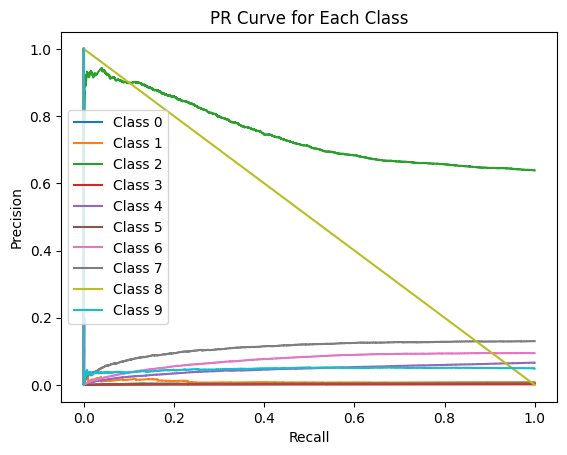

Results saved to map_results.csv
IOU values have been saved to /usr/local/qai/mnt/ip/job_result/1/1/downloads/bboxes_iou_values/bboxes_iou_values.csv


In [21]:
if __name__ == '__main__':
    main()

### #11 License

[required]

In [22]:
ait_owner='AIST'
ait_creation_year='2025'

### #12 Deployment

[uneditable] 

In [23]:
if not is_ait_launch:
    from ait_sdk.deploy import prepare_deploy
    from ait_sdk.license.license_generator import LicenseGenerator
    
    current_dir = %pwd
    prepare_deploy(ait_sdk_name, current_dir, requirements_path)
    
    # output License.txt
    license_generator = LicenseGenerator()
    license_generator.write('../top_dir/LICENSE.txt', ait_creation_year, ait_owner)
